# Project - Solar Energy Production Forecasting
## Part 1 - Load data + EDA

Steps:
- Load train and test datasets
- Ensure chronological order (no shuffling)
- Create a 70/30 Train/Validation split **by time**
- Perform minimal sanity checks (shape, missing values, target leakage)

### Import Packages

In [2]:
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict

### Load Datasets

In [3]:
#loading datasets and basic checks
TRAIN_URL = "https://raw.githubusercontent.com/LeHoangViet03/Fintech-CYTech/main/Energy_Production_Train.csv"
TEST_URL  = "https://raw.githubusercontent.com/LeHoangViet03/Fintech-CYTech/main/Energy_Production_Test.csv"

train_df = pd.read_csv(TRAIN_URL)
test_df  = pd.read_csv(TEST_URL)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

display(train_df.head())
display(test_df.head())

Train shape: (176505, 17)
Test shape : (59376, 17)


,UTC Time,Plant_ID,Energy_Production,Benchmark,Day-Night,Temperature descriptor,Comfort level,Visibility,Probability of precipitation for last hour,Rainfall amount for last hour,Dew point,Temperature,Wind direction,Precipitation descriptor,Sky descriptor,Humidity,Wind speed
0,2020-01-04 00:00:00+00:00,0,0.0,0.0,N,4.0,1.23,17.21,1.0,0.0,0.0,2.5,277.0,0,2.0,84.0,5.04
1,2020-01-04 01:00:00+00:00,0,0.0,0.0,N,4.0,0.28,17.39,1.0,0.0,-0.3,1.8,290.0,0,2.0,86.0,5.40
2,2020-01-04 02:00:00+00:00,0,0.0,0.0,N,4.0,-0.89,18.57,0.0,0.0,-0.7,0.9,297.0,0,2.0,89.0,5.76
3,2020-01-04 03:00:00+00:00,0,0.0,0.0,N,4.0,-1.96,19.75,0.0,0.0,-1.1,0.1,300.0,0,2.0,92.0,6.12
4,2020-01-04 04:00:00+00:00,0,0.0,0.0,N,3.0,-2.30,19.93,0.0,0.0,-1.4,-0.2,299.0,0,2.0,92.0,6.12


,UTC Time,Plant_ID,Energy_Production,Benchmark,Day-Night,Temperature descriptor,Comfort level,Visibility,Probability of precipitation for last hour,Rainfall amount for last hour,Dew point,Temperature,Wind direction,Precipitation descriptor,Sky descriptor,Humidity,Wind speed
0,2021-08-26 00:00:00+00:00,0,0.004,0.004,N,8.0,17.50,21.32,0.0,0.0,13.1,17.5,345.0,0,7.0,76.0,6.48
1,2021-08-26 01:00:00+00:00,0,0.004,0.004,N,8.0,17.10,19.41,0.0,0.0,13.0,17.1,341.0,0,7.0,77.0,6.12
2,2021-08-26 02:00:00+00:00,0,0.004,0.004,N,6.0,16.50,20.50,0.0,0.0,12.8,16.5,341.0,0,7.0,79.0,5.76
3,2021-08-26 03:00:00+00:00,0,0.004,0.004,N,6.0,15.80,20.58,0.0,0.0,12.6,15.8,342.0,0,7.0,81.0,5.40
4,2021-08-26 04:00:00+00:00,0,0.004,0.004,D,6.0,15.65,22.67,0.0,0.0,12.5,15.2,359.0,0,8.0,84.0,5.04


### Parse dates and check `NaNs`

In [4]:
time_col = 'UTC Time'

train_df[time_col] = pd.to_datetime(train_df[time_col], errors="coerce")
test_df[time_col]  = pd.to_datetime(test_df[time_col], errors="coerce")

train_df = train_df.sort_values(time_col).reset_index(drop=True)
test_df  = test_df.sort_values(time_col).reset_index(drop=True)

In [5]:
#checking for missing values

def missing_report(df, name='df'):
    miss = df.isna().mean().sort_values(ascending=False)
    miss = miss[miss>0]
    print(f"\nMissingness report — {name}")
    if len(miss) == 0:
        print("No missing values")
        return
    display((miss * 100) * 100).round(2).to_frame('% of missing values')

missing_report(train_df, "train_df")
missing_report(test_df, "test_df")


Missingness report — train_df
No missing values

Missingness report — test_df
No missing values


### Joining both datasets for a more in depht EDA

In [6]:
#joining both dfs for EDA
df = pd.concat([train_df, test_df], join="inner").sort_values("UTC Time").sort_values("Plant_ID")
df.shape

(235881, 17)

In [7]:
df.describe()

,Plant_ID,Energy_Production,Benchmark,Temperature descriptor,Comfort level,Visibility,Probability of precipitation for last hour,Rainfall amount for last hour,Dew point,Temperature,Wind direction,Precipitation descriptor,Sky descriptor,Humidity,Wind speed
count,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,235881.000000,2.358810e+05,235881.000000,235881.000000,235881.000000
mean,7.670859,0.008685,0.008677,6.076560,11.535787,18.994054,10.469979,0.010241,6.796013,12.109901,143.582056,-3.277474e+06,9.581433,72.889347,7.436998
std,4.577249,0.014589,0.014576,1.945064,9.347031,8.756769,17.102289,0.040474,6.631462,8.387371,114.718993,8.383085e+07,4.858372,16.940525,2.438261
min,0.000000,0.000000,0.000000,3.000000,-10.240000,0.000000,0.000000,0.000000,-13.100000,-7.600000,0.000000,-2.147484e+09,1.000000,15.000000,0.160000
25%,4.000000,0.000000,0.000000,4.000000,4.200000,14.000000,1.000000,0.000000,1.800000,5.500000,37.000000,0.000000e+00,7.000000,61.000000,5.760000
50%,8.000000,0.000000,0.000000,6.000000,9.960000,19.090000,4.000000,0.000000,6.200000,10.700000,112.000000,0.000000e+00,8.000000,77.000000,7.200000
75%,12.000000,0.012000,0.012000,8.000000,18.300000,23.260000,9.000000,0.000000,12.100000,18.300000,231.000000,0.000000e+00,15.000000,87.000000,8.640000
max,15.000000,0.097000,0.097000,12.000000,39.840000,73.850000,84.000000,0.650000,22.700000,35.600000,359.000000,4.600000e+01,18.000000,99.000000,27.000000


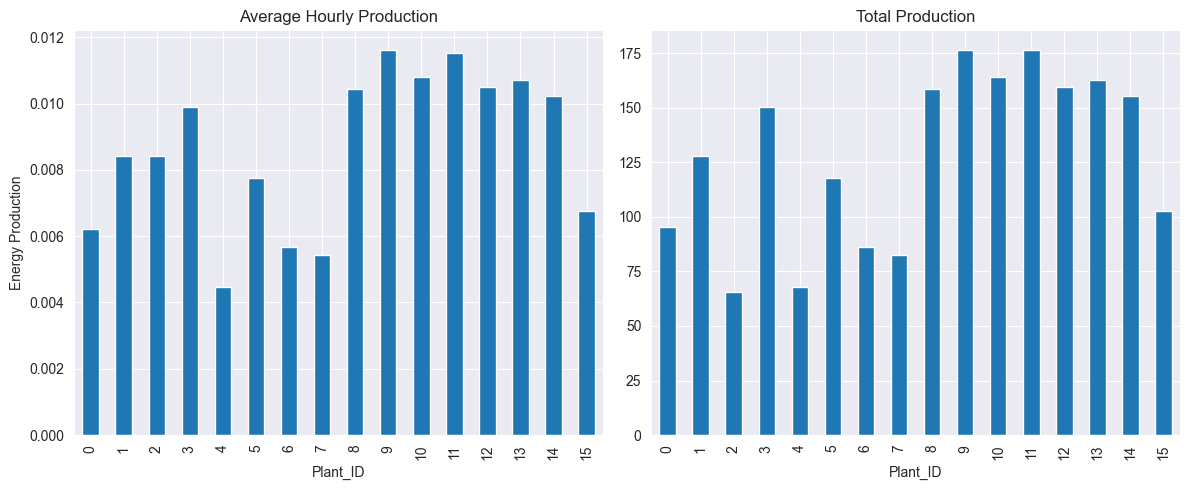

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

df.groupby('Plant_ID')['Energy_Production'].mean().plot(kind='bar', ax=axes[0], title="Average Hourly Production")
axes[0].set_ylabel("Energy Production")

df.groupby('Plant_ID')['Energy_Production'].sum().plot(kind='bar', ax=axes[1], title="Total Production")
plt.tight_layout()
plt.show()

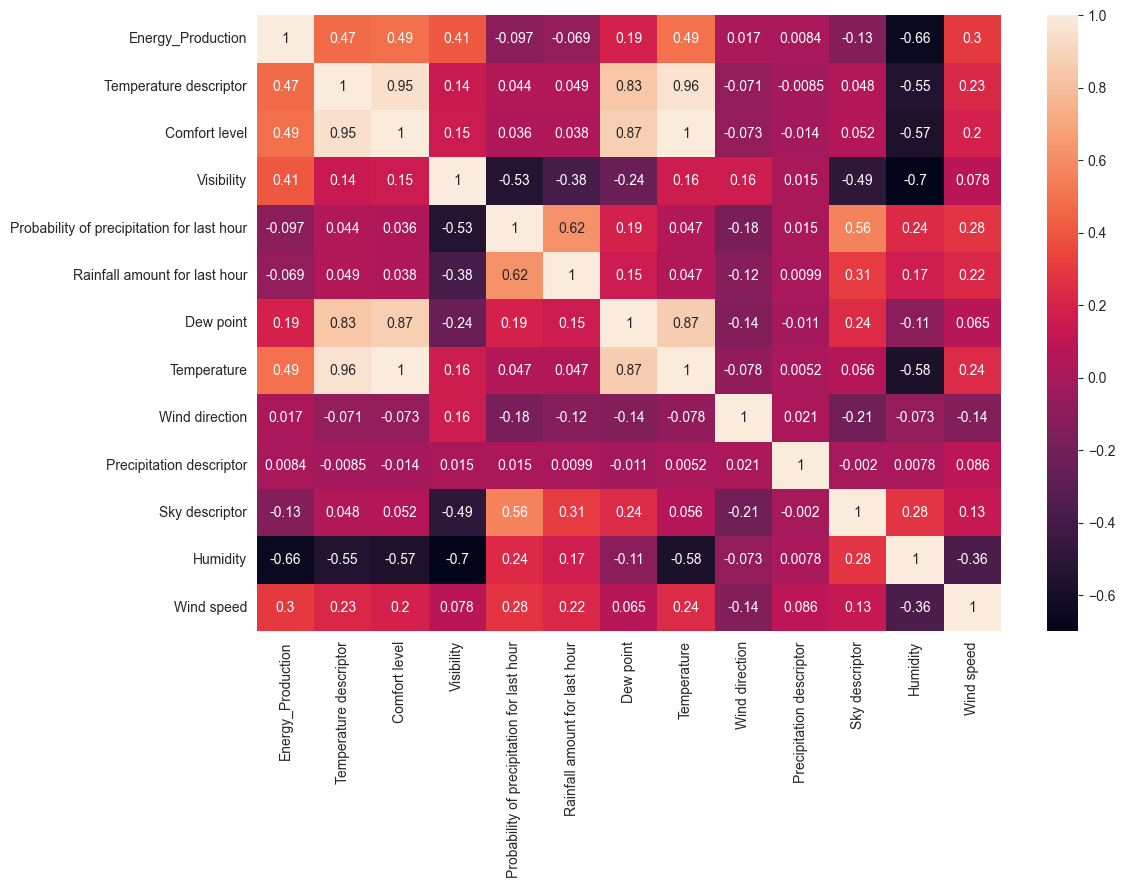

In [9]:
import seaborn as sns

corr = df[['Energy_Production',
       'Temperature descriptor', 'Comfort level', 'Visibility',
       'Probability of precipitation for last hour',
       'Rainfall amount for last hour', 'Dew point', 'Temperature',
       'Wind direction', 'Precipitation descriptor', 'Sky descriptor',
       'Humidity', 'Wind speed']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True)
plt.show()

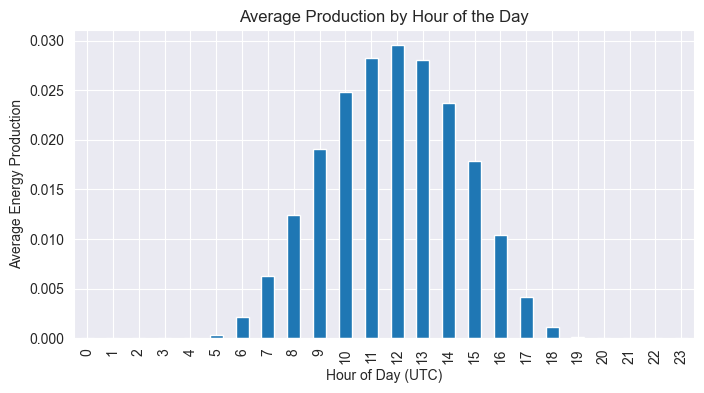

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))

df['UTC Time'] = pd.to_datetime(df['UTC Time'])
df['hour'] = df['UTC Time'].dt.hour

(
    df.groupby('hour')['Energy_Production']
      .mean()
      .plot(
          kind='bar',
          ax=ax,
          title="Average Production by Hour of the Day"
      )
)

ax.set_xlabel("Hour of Day (UTC)")
ax.set_ylabel("Average Energy Production")
plt.show()

### Variance by plant

In [11]:
plant_variance = (df.groupby('Plant_ID')['Energy_Production'].agg(
          variance='var',
          std='std',
          mean='mean',
          count='count')
      .sort_values('variance', ascending=False))

display(plant_variance)

,variance,std,mean,count
Plant_ID,,,,
9,0.000338,0.018372,0.011623,15191
11,0.000325,0.018034,0.011523,15311
13,0.000295,0.017163,0.010709,15191
10,0.000292,0.017080,0.010802,15191
8,0.000278,0.016684,0.010434,15191
12,0.000275,0.016571,0.010493,15191
14,0.000264,0.016245,0.010231,15191
3,0.000258,0.016059,0.009881,15191
1,0.000192,0.013864,0.008413,15191


# Part 2 Feature Engineering

### Cyclical Feature Encoding

Some variables represent cyclical phenomena rather than linear quantities.

- Hour of day (0–23) is cyclical: hour 23 is close to hour 0.
- Wind direction (0–359°) is circular: 359° is close to 0°.

To preserve this structure, we apply sine and cosine transformations. This allows machine learning models to learn smooth periodic patterns
without artificial discontinuities.

In [12]:
# Cyclical encoding: hour of day
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Cyclical encoding: wind direction (degrees)
df['wind_dir_rad'] = np.deg2rad(df['Wind direction'])
df['wind_dir_sin'] = np.sin(df['wind_dir_rad'])
df['wind_dir_cos'] = np.cos(df['wind_dir_rad'])

# Drop intermediate column
df.drop(columns=['wind_dir_rad'], inplace=True)

In [13]:
# Ensure proper ordering
df = df.sort_values(['Plant_ID', 'UTC Time']).reset_index(drop=True)

### Panel-Safe Lag and Rolling Features

The dataset is panel data, with observations indexed by `Plant_ID` and `UTC time`. To avoid data leakage:
- All lagged and rolling features are computed **for each plant**
- Rolling statistics only use **past values** via a shift
- The data is sorted by time before feature construction

These features allow the model to capture short-term persistence and
local trends in energy production.


In [25]:
def add_time_and_cyclical_features(d):
    d = d.copy()
    d["UTC Time"] = pd.to_datetime(d["UTC Time"])
    d["hour"] = d["UTC Time"].dt.hour

    d["hour_sin"] = np.sin(2 * np.pi * d["hour"] / 24)
    d["hour_cos"] = np.cos(2 * np.pi * d["hour"] / 24)

    d["wind_dir_sin"] = np.sin(np.deg2rad(d["Wind direction"]))
    d["wind_dir_cos"] = np.cos(np.deg2rad(d["Wind direction"]))
    return d

def add_panel_lags_and_rolls(d, lags=(1,3,6,12,24), windows=(3,6,12,24)):
    d = d.copy()
    d = d.sort_values(["Plant_ID", "UTC Time"]).reset_index(drop=True)

    for lag in lags:
        d[f"Energy_Production_lag_{lag}"] = d.groupby("Plant_ID")["Energy_Production"].shift(lag)

    for w in windows:
        d[f"EP_roll_mean_{w}"] = (
            d.groupby("Plant_ID")["Energy_Production"].shift(1).rolling(w).mean()
        )
        d[f"EP_roll_std_{w}"] = (
            d.groupby("Plant_ID")["Energy_Production"].shift(1).rolling(w).std()
        )
    return d

train_feat = add_panel_lags_and_rolls(add_time_and_cyclical_features(train_raw))
test_feat  = add_panel_lags_and_rolls(add_time_and_cyclical_features(test_raw))


### PCA on Weather Features

Weather variables exhibit strong multicollinearity.We apply Principal Component Analysis (PCA) to continuous weather features only.

Steps:
- Standardize all features
- Retain components explaining 95% of total variance
- Replace original weather variables with PCA components

This reduces dimensionality while preserving most of the information, and allows us to compare model performance with and without PCA.


# Step 3 — Model Selection & Tuning

In this step we:
1. Build a leakage proof Train/Validation split (no shuffling, last 30% as validation).
2. Compare multiple model families:
   - Linear: Ridge, Lasso
   - Distance-based: KNN
   - Tree-based: Random Forest
   - Boosting: Gradient Boosting (baseline boosting)
3. Evaluate all models using:
   - RMSE (lower is better)
   - R² (higher is better)

We implement the two strategies:
- **Global Model**: one model trained on all plants using `Plant_ID` as a feature.
- **Local Models**: one model per `Plant_ID` (15 separate models), then aggregate performance.

In [23]:
# re-separating datasets
train_raw = train_df.copy()
test_raw  = test_df.copy()

# Ensure sorted for time  consistency
train_raw = train_raw.sort_values(["UTC Time", "Plant_ID"]).reset_index(drop=True)
test_raw  = test_raw.sort_values(["UTC Time", "Plant_ID"]).reset_index(drop=True)

### Implementing Global Models

In [41]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

TARGET_COL = "Energy_Production"
BENCH_COL  = "Benchmark"
TIME_COL   = "UTC Time"

# Feature columns: drop target, benchmark & time
drop_cols = [TARGET_COL, BENCH_COL, TIME_COL]
feature_cols_eval = [c for c in train_feat.columns if c not in drop_cols]

# X/y
X_train = train_feat[feature_cols_eval].copy()
y_train = train_feat[TARGET_COL].copy()

X_test  = test_feat[feature_cols_eval].copy()
y_test  = test_feat[TARGET_COL].copy()

# Numeric/categorical split
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

# Preprocess
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95, random_state=42))
])
categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, numeric_cols),
        ("cat", categorical_preprocess, categorical_cols)
    ]
)

# Models + grids (your set)
models = {
    "Ridge": Pipeline([("prep", preprocess), ("model", Ridge(random_state=42))]),
    "Lasso": Pipeline([("prep", preprocess), ("model", Lasso(random_state=42, max_iter=20000))]),
    "KNN": Pipeline([("prep", preprocess), ("model", KNeighborsRegressor())]),
    "RandomForest": Pipeline([("prep", preprocess), ("model", RandomForestRegressor(random_state=42, n_jobs=-1))]),
    "GradBoost": Pipeline([("prep", preprocess), ("model", GradientBoostingRegressor(random_state=42))]),
}

param_grids = {
    "Ridge": {"model__alpha": [0.1, 1.0, 10.0, 100.0]},
    "Lasso": {"model__alpha": [1e-4, 1e-3, 1e-2, 1e-1]},
    "KNN":   {"model__n_neighbors": [5, 15, 30], "model__weights": ["uniform", "distance"]},
    "RandomForest": {"model__n_estimators": [200], "model__max_depth": [None, 10, 20]},
    "GradBoost": {"model__n_estimators": [200], "model__learning_rate": [0.05, 0.1], "model__max_depth": [2, 3]},
}

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def eval_train_test(fitted, Xtr, ytr, Xte, yte):
    pred_tr = np.clip(fitted.predict(Xtr), 0, None)
    pred_te = np.clip(fitted.predict(Xte), 0, None)
    return (
        rmse(ytr, pred_tr), float(r2_score(ytr, pred_tr)),
        rmse(yte, pred_te), float(r2_score(yte, pred_te)),
        pred_te
    )

# TimeSeries CV for tuning
tscv = TimeSeriesSplit(n_splits=3)

rows = []
test_predictions = {}  # store predictions for plotting later

for name, pipe in models.items():
    grid = GridSearchCV(
        pipe,
        param_grids[name],
        scoring="neg_root_mean_squared_error",
        cv=tscv,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best = grid.best_estimator_

    rmse_tr, r2_tr, rmse_te, r2_te, pred_te = eval_train_test(best, X_train, y_train, X_test, y_test)
    test_predictions[name] = pred_te

    rows.append({
        "model": name,
        "rmse_train": rmse_tr,
        "r2_train": r2_tr,
        "rmse_test": rmse_te,
        "r2_test": r2_te,
        "best_params": grid.best_params_
    })

results_all = pd.DataFrame(rows).sort_values("rmse_test").reset_index(drop=True)

# Benchmark metrics (train + test)
bench_train = np.clip(train_feat[BENCH_COL].values, 0, None)
bench_test  = np.clip(test_feat[BENCH_COL].values, 0, None)

bench_row = {
    "model": "Benchmark",
    "rmse_train": rmse(y_train, bench_train),
    "r2_train": float(r2_score(y_train, bench_train)),
    "rmse_test": rmse(y_test, bench_test),
    "r2_test": float(r2_score(y_test, bench_test)),
    "best_params": None
}

results_all = pd.concat([results_all, pd.DataFrame([bench_row])], ignore_index=True)
results_all = results_all.sort_values("rmse_test").reset_index(drop=True)

# Improvement vs benchmark on test
rmse_bench_test = bench_row["rmse_test"]
results_all["rmse_improve_vs_bench_%"] = 100 * (rmse_bench_test - results_all["rmse_test"]) / rmse_bench_test

display(results_all)

,model,rmse_train,r2_train,rmse_test,r2_test,best_params,rmse_improve_vs_bench_%
0,RandomForest,8.668965e-04,0.996828,0.003567,0.903834,"{'model__max_depth': None, 'model__n_estimator...",49.526688
1,GradBoost,3.859526e-03,0.937118,0.003691,0.897032,"{'model__learning_rate': 0.1, 'model__max_dept...",47.772320
2,KNN,5.837723e-10,1.000000,0.003802,0.890719,"{'model__n_neighbors': 5, 'model__weights': 'd...",46.195055
3,Lasso,4.398873e-03,0.918315,0.003943,0.882500,{'model__alpha': 0.0001},44.208300
4,Ridge,4.377687e-03,0.919100,0.003969,0.880947,{'model__alpha': 0.1},43.840730
5,Benchmark,7.659262e-03,0.752354,0.007067,0.622516,None,0.000000


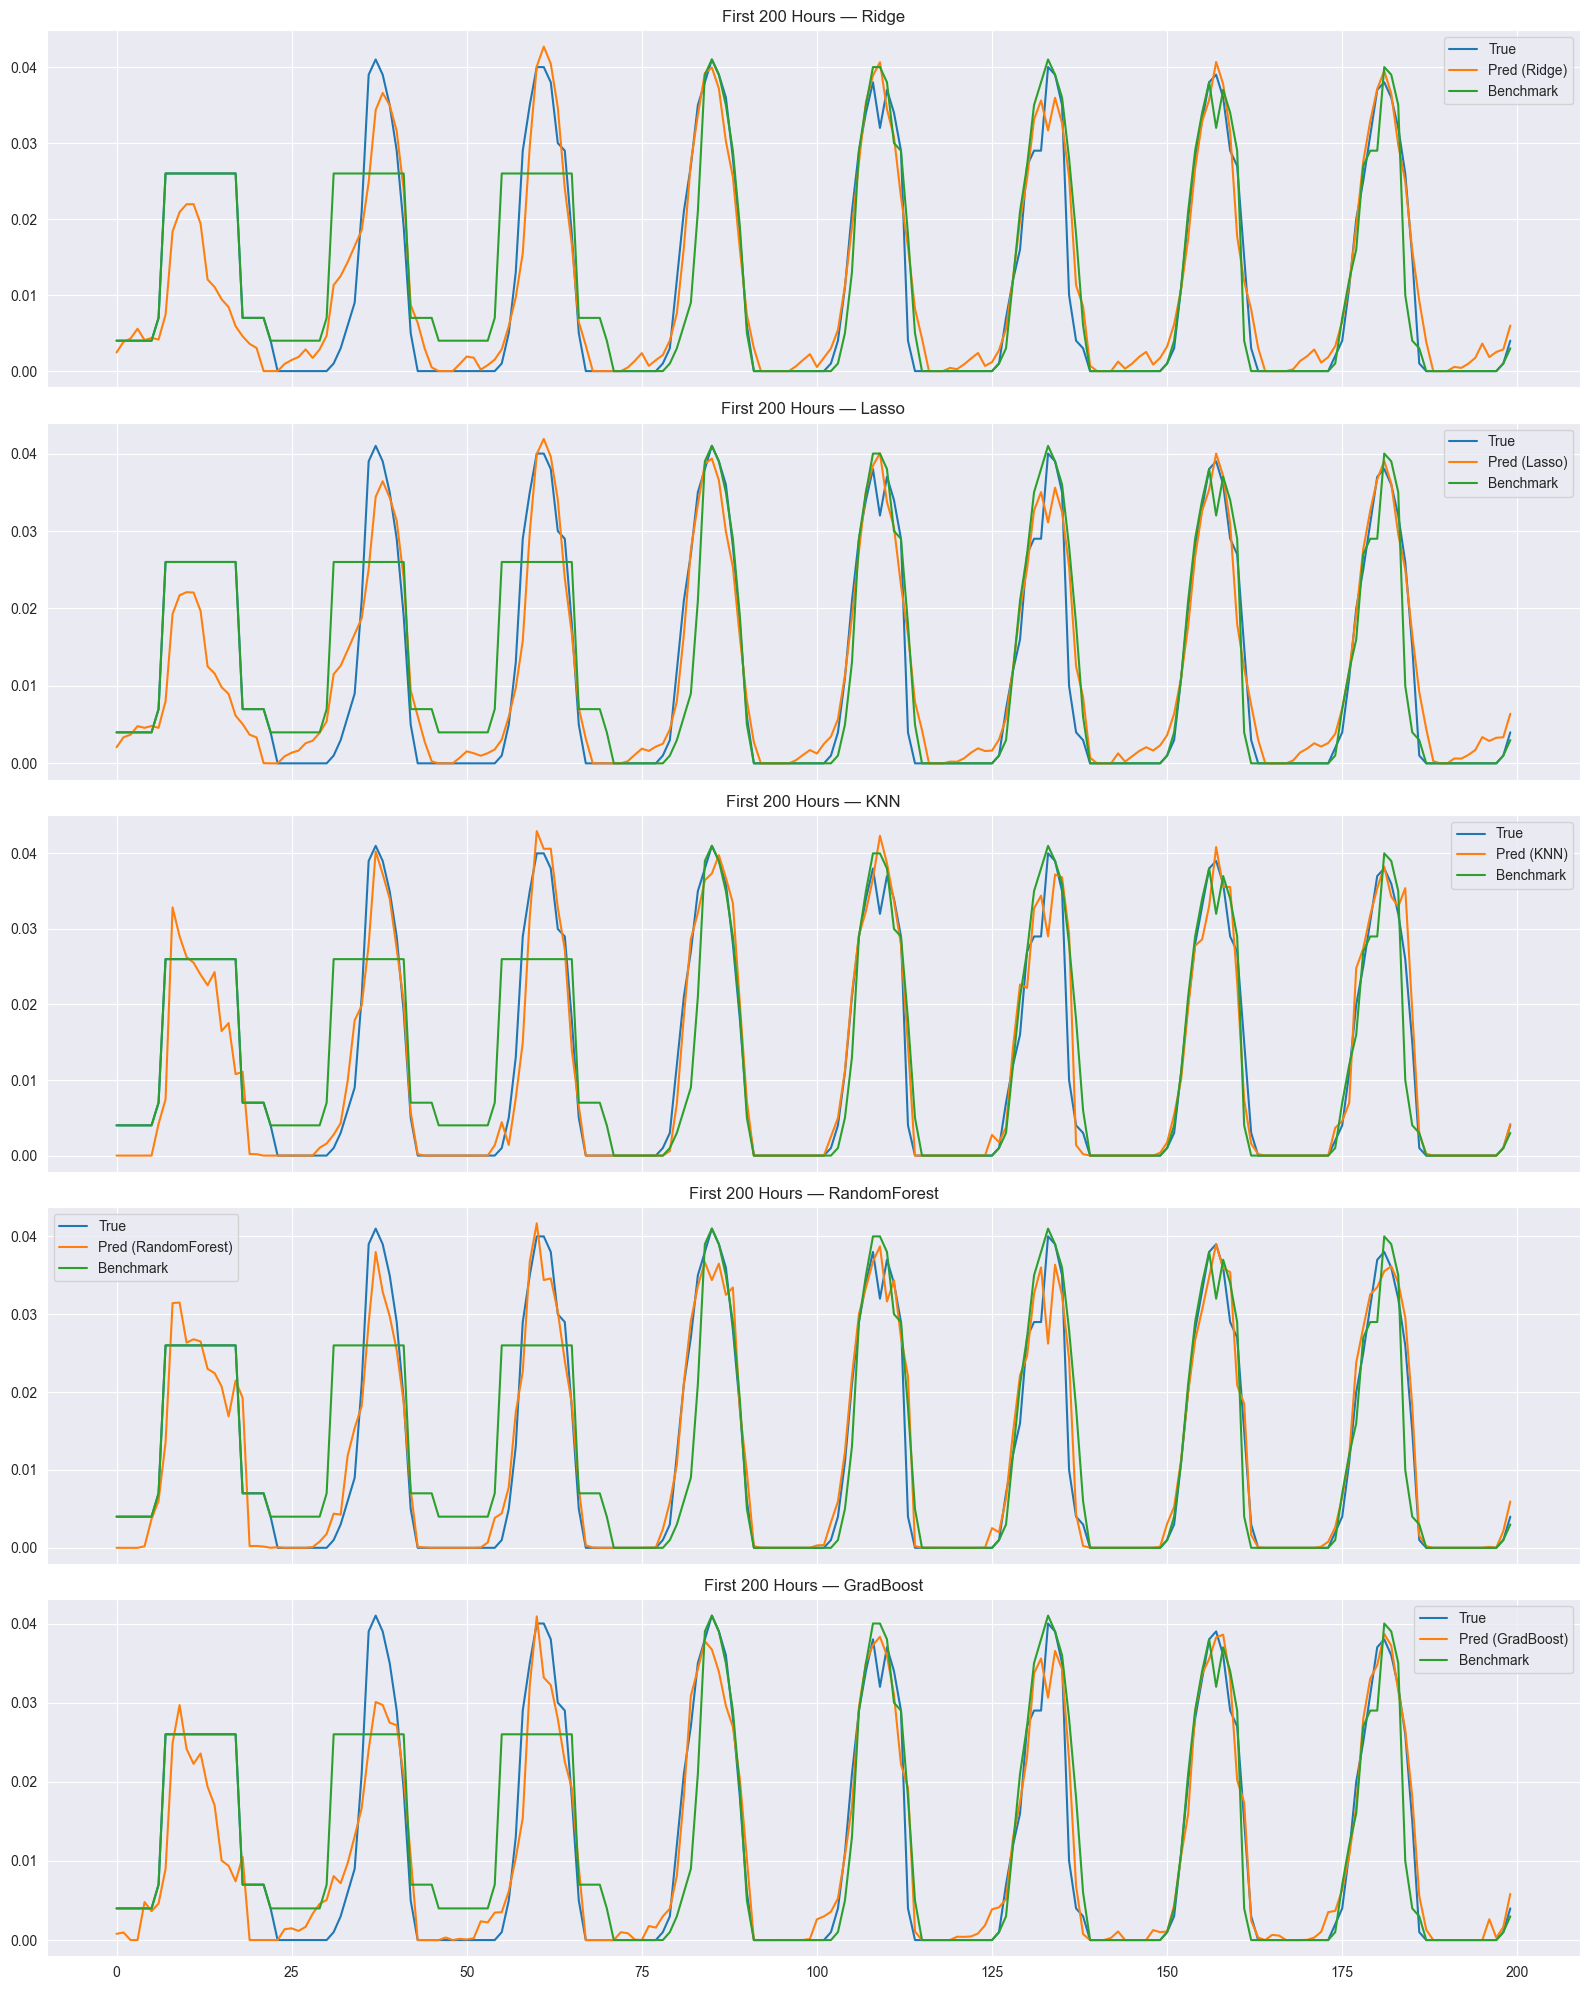

In [42]:
models_to_plot = [m for m in test_predictions.keys()]  # all ML models
n = 200
y_true = y_test.values[:n]
y_bench = np.clip(test_feat[BENCH_COL].values[:n], 0, None)

fig, axes = plt.subplots(len(models_to_plot), 1, figsize=(16, 4*len(models_to_plot)), sharex=True)

if len(models_to_plot) == 1:
    axes = [axes]

for ax, m in zip(axes, models_to_plot):
    ax.plot(y_true, label="True")
    ax.plot(test_predictions[m][:n], label=f"Pred ({m})")
    ax.plot(y_bench, label="Benchmark")
    ax.set_title(f"First {n} Hours — {m}")
    ax.legend()

plt.tight_layout()
plt.show()

### Implementing Local Models

In [ ]:
### Implementing Local Models (FIXED: pipeline matches local_feature_cols)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

PLANT_COL = "Plant_ID"

# Local features: remove Plant_ID because within plant it is constant
local_feature_cols = [c for c in feature_cols_eval if c != PLANT_COL]

# Build X/y "templates" for dtype detection (important!)
X_local_template = train_feat[local_feature_cols].copy()

# Numeric/categorical split for LOCAL feature set
local_numeric_cols = X_local_template.select_dtypes(include=[np.number]).columns.tolist()
local_categorical_cols = [c for c in X_local_template.columns if c not in local_numeric_cols]

# LOCAL preprocess (same logic, but columns aligned to local_feature_cols)
local_numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95, random_state=42))
])

local_categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

local_preprocess = ColumnTransformer(
    transformers=[
        ("num", local_numeric_preprocess, local_numeric_cols),
        ("cat", local_categorical_preprocess, local_categorical_cols)
    ]
)

# LOCAL models (use local_preprocess)
local_models = {
    "Ridge": Pipeline([("prep", local_preprocess), ("model", Ridge(random_state=42))]),
    "Lasso": Pipeline([("prep", local_preprocess), ("model", Lasso(random_state=42, max_iter=20000))]),
    "KNN": Pipeline([("prep", local_preprocess), ("model", KNeighborsRegressor())]),
    "RandomForest": Pipeline(
        [("prep", local_preprocess), ("model", RandomForestRegressor(random_state=42, n_jobs=-1))]),
    "GradBoost": Pipeline([("prep", local_preprocess), ("model", GradientBoostingRegressor(random_state=42))]),
}

# Same grids as before
local_param_grids = param_grids

# Time-series CV for tuning within each plant
tscv_local = TimeSeriesSplit(n_splits=3)

local_rows = []
local_test_predictions = {}

plant_ids = sorted(train_feat[PLANT_COL].unique())

for pid in plant_ids:
    tr_p = train_feat[train_feat[PLANT_COL] == pid].sort_values("UTC Time")
    te_p = test_feat[test_feat[PLANT_COL] == pid].sort_values("UTC Time")

    if len(tr_p) < 200 or len(te_p) < 50:
        print(f"Skipping Plant {pid} (train={len(tr_p)}, test={len(te_p)})")
        continue

    X_tr = tr_p[local_feature_cols].copy()
    y_tr = tr_p[TARGET_COL].copy()

    X_te = te_p[local_feature_cols].copy()
    y_te = te_p[TARGET_COL].copy()

    for model_name, pipe in local_models.items():
        grid = GridSearchCV(
            estimator=pipe,
            param_grid=local_param_grids[model_name],
            scoring="neg_root_mean_squared_error",
            cv=tscv_local,
            n_jobs=-1
        )
        grid.fit(X_tr, y_tr)
        best = grid.best_estimator_

        pred_tr = np.clip(best.predict(X_tr), 0, None)
        pred_te = np.clip(best.predict(X_te), 0, None)

        local_rows.append({
            "Plant_ID": pid,
            "model": f"Local-{model_name}",
            "rmse_train": rmse(y_tr, pred_tr),
            "r2_train": float(r2_score(y_tr, pred_tr)),
            "rmse_test": rmse(y_te, pred_te),
            "r2_test": float(r2_score(y_te, pred_te)),
            "best_params": grid.best_params_
        })

        local_test_predictions[(pid, model_name)] = {
            "y_true": y_te.values,
            "y_pred": pred_te,
            "utc_time": te_p["UTC Time"].values,
            "benchmark": np.clip(te_p["Benchmark"].values, 0, None) if "Benchmark" in te_p.columns else None
        }

local_results_df = pd.DataFrame(local_rows).sort_values(["Plant_ID", "rmse_test"])
display(local_results_df)


#### A) Average metrics per model family across plants

In [ ]:
local_summary_by_model = (
    local_results_df
    .groupby("model")[["rmse_train", "r2_train", "rmse_test", "r2_test"]]
    .mean()
    .sort_values("rmse_test")
)

display(local_summary_by_model)

#### B) Best local model per plant (select by lowest test RMSE)

In [ ]:
best_local_per_plant = (
    local_results_df.sort_values(["Plant_ID", "rmse_test"])
    .groupby("Plant_ID")
    .head(1)
    .reset_index(drop=True)
)

display(best_local_per_plant[["Plant_ID", "model", "rmse_test", "r2_test", "best_params"]])

#### C) “Local strategy overall score” (mean of best per-plant models)

In [ ]:
local_best_overall = best_local_per_plant[["rmse_train", "r2_train", "rmse_test", "r2_test"]].mean()
print("Local strategy (best-per-plant average):")
display(local_best_overall.to_frame("mean_metric"))

In [ ]:
# Choose a plant to display (example: plant 0)
pid = 0

# Choose that plant's best model (based on best_local_per_plant table)
best_model_for_pid = best_local_per_plant.loc[best_local_per_plant["Plant_ID"] == pid, "model"].iloc[0]
model_name = best_model_for_pid.replace("Local-", "")

pack = local_test_predictions[(pid, model_name)]

# sort by time for clean plot
order = np.argsort(pack["utc_time"])
y_true = pack["y_true"][order]
y_pred = pack["y_pred"][order]
y_bench = pack["benchmark"][order] if pack["benchmark"] is not None else None

n = min(100, len(y_true))

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_true[:n], label="True")
ax.plot(y_pred[:n], label=f"Prediction (Plant {pid}, {model_name})")
if y_bench is not None:
    ax.plot(y_bench[:n], label="Benchmark")

ax.set_title(f"Local Model Visual Proof — Plant {pid} (first {n} test hours)")
ax.set_xlabel("Hour index")
ax.set_ylabel("Energy Production")
ax.legend()
plt.tight_layout()
plt.show()

# Part 4 — Model Interpretation (XAI)

We interpret the selected model using:

## Global explanations
- **Permutation Importance**: model-agnostic, measures how much model performance degrades when a feature is shuffled.
- **SHAP Summary**: shows which features drive predictions and whether higher/lower values push predictions up/down.

## Local explanations
- **SHAP Waterfall**: explains single predictions (e.g., a peak production hour or a high-error hour).
We illustrate local explanations on:
1) a **peak production** instance
2) a **largest-error** instance

In [ ]:
from sklearn.inspection import permutation_importance


# A) GLOBAL: best model by test RMSE (exclude Benchmark)
best_global_name = results_all[results_all["model"] != "Benchmark"].iloc[0]["model"]
print("Best GLOBAL model:", best_global_name)

# Refit the best global model on full training data (optional but standard for interpretation)
best_global_pipe = GridSearchCV(
    models[best_global_name],
    param_grids[best_global_name],
    scoring="neg_root_mean_squared_error",
    cv=TimeSeriesSplit(n_splits=3),
    n_jobs=-1
).fit(X_train, y_train).best_estimator_


# B) LOCAL: best model for a selected plant (pid)
pid = 0  # change this if you want another plant
best_local_label = best_local_per_plant.loc[best_local_per_plant["Plant_ID"] == pid, "model"].iloc[0]
best_local_name = best_local_label.replace("Local-", "")
print(f"Best LOCAL model for Plant {pid}:", best_local_name)

# Build plant-specific datasets (must match your training procedure)
tr_p = train_feat[train_feat["Plant_ID"] == pid].sort_values("UTC Time")
te_p = test_feat[test_feat["Plant_ID"] == pid].sort_values("UTC Time")

X_tr_local = tr_p[local_feature_cols].copy()
y_tr_local = tr_p[TARGET_COL].copy()

X_te_local = te_p[local_feature_cols].copy()
y_te_local = te_p[TARGET_COL].copy()

best_local_pipe = GridSearchCV(
    models[best_local_name],
    param_grids[best_local_name],
    scoring="neg_root_mean_squared_error",
    cv=TimeSeriesSplit(n_splits=3),
    n_jobs=-1
).fit(X_tr_local, y_tr_local).best_estimator_
